In [1]:
!pip install yfinance
from IPython.display import clear_output
clear_output()

In [2]:
# let us set the device
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [3]:
#In this notebook, we are going to train a reinforcement learning system
#!pip install yfinance
import yfinance as yf
from collections import namedtuple,deque
from torch import nn
import torch
from torch import optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import random

In [4]:
#STATE_SPACE = 28
STATE_SPACE = 34
ACTION_SPACE = 3

ACTION_LOW = -1
ACTION_HIGH = 1

GAMMA = 0.9995
TAU = 1e-3
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 0.9

MEMORY_LEN = 10000
MEMORY_THRESH = 500
BATCH_SIZE = 200

LR_DQN = 5e-4

LEARN_AFTER = MEMORY_THRESH
LEARN_EVERY = 3
UPDATE_EVERY = 9

COST = 3e-4
CAPITAL = 100000
NEG_MUL = 2

### Now we need to generate the observation space. The following code snippet does the same. First, it downloads the required time series data for the given ticker, date and frequency from the Yahoo Finance website using yfinance python module. Later, it engineers the required features for the observation space.

In [5]:
class DataGetter:
  """
  The class for getting data for assets.
  """

  def __init__(self, asset="BTC-USD", start_date=None, end_date=None, freq="1d",
               timeframes=[1,2,5, 10, 20, 40]):
    self.asset = asset
    self.sd = start_date
    self.ed = end_date
    self.freq = freq

    self.timeframes = timeframes
    self.getData()

    self.scaler = StandardScaler()
    self.scaler.fit(self.data[:, 1:])


  def getData(self):

    asset = self.asset
    if self.sd is not None and self.ed is not None:
      df =  yf.download([asset], start=self.sd, end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, end=self.ed, interval=self.freq)
    elif self.sd is None and self.ed is not None:
      df =  yf.download([asset], end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], end=self.ed, interval=self.freq)
    elif self.sd is not None and self.ed is None:
      df =  yf.download([asset], start=self.sd, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, interval=self.freq)
    else:
      df = yf.download([asset], period="max", interval=self.freq)
      df_spy = yf.download(["BTC-USD"], interval=self.freq)

    # Reward - Not included in Observation Space.
    #print(df_spy.head())
    df["rf"] = df["Adj Close"].pct_change().shift(-1)

    # Returns and Trading Volume Changes
    for i in self.timeframes:
      df_spy[f"spy_ret-{i}"] = df_spy["Adj Close"].pct_change(i)
      df_spy[f"spy_v-{i}"] = df_spy["Volume"].pct_change(i)

      df[f"r-{i}"] = df["Adj Close"].pct_change(i)
      df[f"v-{i}"] = df["Volume"].pct_change(i)

    # Volatility
    for i in [5, 10, 20, 40]:
      df[f'sig-{i}'] = np.log(1 + df["r-1"]).rolling(i).std()

    # Moving Average Convergence Divergence (MACD)
    df["macd_lmw"] = df["r-1"].ewm(span=26, adjust=False).mean()
    df["macd_smw"] = df["r-1"].ewm(span=12, adjust=False).mean()
    df["macd_bl"] = df["r-1"].ewm(span=9, adjust=False).mean()
    df["macd"] = df["macd_smw"] - df["macd_lmw"]

    # Relative Strength Indicator (RSI)
    rsi_lb = 5
    pos_gain = df["r-1"].where(df["r-1"] > 0, 0).ewm(rsi_lb).mean()
    neg_gain = df["r-1"].where(df["r-1"] < 0, 0).ewm(rsi_lb).mean()
    rs = np.abs(pos_gain/neg_gain)
    df["rsi"] = 100 * rs/(1 + rs)

    # Bollinger Bands
    bollinger_lback = 10
    df["bollinger"] = df["r-1"].ewm(bollinger_lback).mean()
    df["low_bollinger"] = df["bollinger"] - 2 * df["r-1"].rolling(bollinger_lback).std()
    df["high_bollinger"] = df["bollinger"] + 2 * df["r-1"].rolling(bollinger_lback).std()

    # SP500
    #print(self.timeframes)
    #df = df.merge(df_spy[[f"spy_ret-{i}" for i in self.timeframes] + [f"spy_sig-{i}" for i in [5, 10, 20, 40]]],
    df = df.merge(df_spy[[f"spy_ret-{i}" for i in self.timeframes]],
                  how="left", right_index=True, left_index=True)

    # Filtering
    for c in df.columns:
      df[c].interpolate('linear', limit_direction='both', inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    self.frame = df
    self.data = np.array(df.iloc[:, 6:])
    return


  def scaleData(self):
    self.scaled_data = self.scaler.fit_transform(self.data[:, 1:])
    return


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx, col_idx=None):
    if col_idx is None:
      return self.data[idx]
    elif col_idx < len(list(self.data.columns)):
      return self.data[idx][col_idx]
    else:
      raise IndexError


### The following snippet is the custom trading environment implementation for trading a single asset. It takes as input the DataGetter class for an asset. While there are a lot of functions in the environment class, the two main functions are step() and reset().

In [6]:
class SingleAssetTradingEnvironment:
  """
  Trading Environment for trading a single asset.
  The Agent interacts with the environment class through the step() function.
  Action Space: {-1: Sell, 0: Do Nothing, 1: Buy}
  """

  def __init__(self, asset_data,
               initial_money=CAPITAL, trans_cost=COST, store_flag=1, asset_ph=0,
               capital_frac=0.2, running_thresh=0.1, cap_thresh=0.3):

    self.past_holding = asset_ph
    self.capital_frac = capital_frac # Fraction of capital to invest each time.
    self.cap_thresh = cap_thresh
    self.running_thresh = running_thresh
    self.trans_cost = trans_cost

    self.asset_data = asset_data
    self.terminal_idx = len(self.asset_data) - 1
    self.scaler = self.asset_data.scaler

    self.initial_cap = initial_money

    self.capital = self.initial_cap
    self.running_capital = self.capital
    self.asset_inv = self.past_holding

    self.pointer = 0
    self.next_return, self.current_state = 0, None
    self.prev_act = 0
    self.current_act = 0
    self.current_reward = 0
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.done = False

    self.store_flag = store_flag
    if self.store_flag == 1:
      self.store = {"action_store": [],
                    "reward_store": [],
                    "running_capital": [],
                    "port_ret": []}


  def reset(self):
    self.capital = self.initial_cap
    self.running_capital = self.capital
    self.asset_inv = self.past_holding

    self.pointer = 0
    self.next_return, self.current_state = self.get_state(self.pointer)
    self.prev_act = 0
    self.current_act = 0
    self.current_reward = 0
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.done = False

    if self.store_flag == 1:
      self.store = {"action_store": [],
                    "reward_store": [],
                    "running_capital": [],
                    "port_ret": []}

    return self.current_state


  def step(self, action):
    self.current_act = action
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.current_reward = self.calculate_reward()
    self.prev_act = self.current_act
    self.pointer += 1
    self.next_return, self.current_state = self.get_state(self.pointer)
    self.done = self.check_terminal()

    if self.done:
      reward_offset = 0
      ret = (self.store['running_capital'][-1]/self.store['running_capital'][-0]) - 1
      if self.pointer < self.terminal_idx:
        reward_offset += -1 * max(0.5, 1 - self.pointer/self.terminal_idx)
      if self.store_flag:
        reward_offset += 10 * ret
      self.current_reward += reward_offset

    if self.store_flag:
      self.store["action_store"].append(self.current_act)
      self.store["reward_store"].append(self.current_reward)
      self.store["running_capital"].append(self.capital)
      info = self.store
    else:
      info = None

    return self.current_state, self.current_reward, self.done, info


  def calculate_reward(self):
    investment = self.running_capital * self.capital_frac
    reward_offset = 0

    # Buy Action
    if self.current_act == 1:
      if self.running_capital > self.initial_cap * self.running_thresh:
        self.running_capital -= investment
        asset_units = investment/self.current_price
        self.asset_inv += asset_units
        self.current_price *= (1 - self.trans_cost)

    # Sell Action
    elif self.current_act == -1:
      if self.asset_inv > 0:
        self.running_capital += self.asset_inv * self.current_price * (1 - self.trans_cost)
        self.asset_inv = 0

    # Do Nothing
    elif self.current_act == 0:
      if self.prev_act == 0:
        reward_offset += -0.1
      pass

    # Reward to give
    prev_cap = self.capital
    self.capital = self.running_capital + (self.asset_inv) * self.current_price
    reward = 100*(self.next_return) * self.current_act - np.abs(self.current_act - self.prev_act) * self.trans_cost
    if self.store_flag==1:
      self.store['port_ret'].append((self.capital - prev_cap)/prev_cap)

    if reward < 0:
      reward *= NEG_MUL  # To make the Agent more risk averse towards negative returns.
    reward += reward_offset

    return reward


  def check_terminal(self):
    if self.pointer == self.terminal_idx:
      return True
    elif self.capital <= self.initial_cap * self.cap_thresh:
      return True
    else:
      return False


  def get_state(self, idx):
    state = self.asset_data[idx][1:]
    state = self.scaler.transform(state.reshape(1, -1))

    state = np.concatenate([state, [[self.capital/self.initial_cap,
                                     self.running_capital/self.capital,
                                     self.asset_inv * self.current_price/self.initial_cap,
                                     self.prev_act]]], axis=-1)

    next_ret = self.asset_data[idx][0]
    return next_ret, state

## Replay Memory

In [7]:
Transition = namedtuple("Transition", ["States", "Actions", "Rewards", "NextStates", "Dones"])


class ReplayMemory:
  """
  Implementation of Agent memory
  """
  def __init__(self, capacity=MEMORY_LEN):
    self.memory = deque(maxlen=capacity)

  def store(self, t):
    self.memory.append(t)

  def sample(self, n):
    a = random.sample(self.memory, n)
    return a

  def __len__(self):
    return len(self.memory)

## Actor and Critic

In [8]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc = nn.Linear(input_dim, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return torch.softmax(self.out(x), dim=-1)


class Critic(nn.Module):
    def __init__(self, input_dim=3):
        super(Critic, self).__init__()
        self.fc = nn.Linear(input_dim, 128)
        self.out = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.out(x)


In [9]:

class A2CAgent:
    def __init__(self, input_dim, n_actions, lr):
        self.actor = Actor(input_dim, n_actions)
        self.critic = Critic(input_dim)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr)

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.actor(state).squeeze()
        #print(probs)
        action = torch.multinomial(probs, num_samples=1)
        return action.item()





```
# This is formatted as code
```

##  Training

In [46]:
if __name__ == "__main__":
    prices = np.random.rand(100)
    assets = DataGetter("XRP-USD", start_date="2015-08-01", end_date="2022-08-30")
    env = SingleAssetTradingEnvironment(assets)
    agent = A2CAgent(input_dim=34, n_actions=3, lr=0.0005)

    N_EPISODES = 20 # No of episodes/epochs
    scores = []
    eps = EPS_START
    act_dict = {0:-1, 1:1, 2:0}
    #ACTIONS=[]
    #REWARDS=[]
    #DATES=[]
    #CLOSES=[]
    #CAPITALS=[]
    for episode in range(N_EPISODES):
        state = env.reset()
        done = False
        total_reward = 0
        #ACTIONS=[]
        #REWARDS=[]
        #DATES=[]
        #CLOSES=[]
        #CAPITALS=[]
        #date=env.asset_data.frame.index
        #close=env.asset_data.frame['Adj Close']
        #DATES.append(date)

        #CLOSES.append(close)

        while not done:
            action = agent.act(state)
            #action = act_dict[actions]
            next_state, reward, done,_ = env.step(action)
            #print(next_state)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            # Compute advantage and update actor and critic
            advantage = reward + (1 - done) * agent.critic(next_state.detach()) - agent.critic(torch.tensor(state, dtype=torch.float32))
            total_reward += reward
            #print(reward)
            #print(state)

            #print(advantage.detach().item())
            #print(action)
            actor_loss = -torch.log(agent.actor(torch.tensor(state, dtype=torch.float32)).squeeze()[action]) * advantage.squeeze().item()

            #print(actor_loss)

            critic_loss = advantage.pow(2)

            agent.optimizer_actor.zero_grad()
            actor_loss.backward()
            agent.optimizer_actor.step()

            agent.optimizer_critic.zero_grad()
            critic_loss.backward()
            agent.optimizer_critic.step()
            #print(next_state)
            #ACTIONS.append(action)
            #REWARDS.append(reward)
            #CAPITALS.append(env.store['running_capital'])


            state = next_state


        print(f"Episode: {episode+1}, Total Reward: {total_reward}")
clear_output()

In [48]:
# test the agent
assets = DataGetter("XRP-USD", start_date="2022-08-30", end_date="2023-08-30")
test_env=SingleAssetTradingEnvironment(assets)

state = test_env.reset()
done = False
ACTIONS=[]
REWARDS=[]
DATES=[]
CLOSES=[]
CAPITALS=[]
date=test_env.asset_data.frame.index
close=test_env.asset_data.frame['Adj Close']
DATES.append(date)
CLOSES.append(close)
while not done:


    action = agent.act(state)
    state, reward, done,_ = test_env.step(action)
    ACTIONS.append(action)
    REWARDS.append(reward)
    CAPITALS.append(test_env.store['running_capital'])



    # Log/analyze the trading performance

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


::
For training the Agent, we shall consider the historical price data from 2015/08/01 to 2022/08/30 and for validation, 2022/08/30 to 2023/08/30.

Deep Learning models typically require a humongous amount of data. For the chosen training period, we have approximately, 1600 data points for each asset which is not enough. So we choose multiple assets to train the agent as it gives us more data points.

In [49]:
print(REWARDS)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 9.408856924872428, -0.0012, -0.1, -0.1, -0.1, -0.1, -0.1, 5.027976797430295, -0.0012, -0.1, -0.1, -0.1, 8.023187679156973, -0.0006, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -71.9396178378751, 37.53156502692963, -0.0012, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 1.6028704634089181, -0.0012, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,

In [50]:
import pandas as pd

In [51]:
print(CLOSES)

[Date
2022-08-30    0.326869
2022-08-31    0.327870
2022-09-01    0.333194
2022-09-02    0.331259
2022-09-03    0.329969
                ...   
2023-08-25    0.526246
2023-08-26    0.523470
2023-08-27    0.523844
2023-08-28    0.523248
2023-08-29    0.540065
Name: Adj Close, Length: 365, dtype: float64]


In [52]:
print(ACTIONS)

[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [53]:
date_list = [date.to_list() for date in DATES]

In [54]:
dates=[]
for i in date_list:
  for j in i:
    dates.append(str(j.date()))

In [55]:
ACTIONS=[0]+ACTIONS
REWARDS=[0]+REWARDS
dates=dates
print(len(dates))
print(len(ACTIONS))
print(dates)

365
365
['2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17', '2022-09-18', '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08', '2022-10-09', '2022-10-10', '2022-10-11', '2022-10-12', '2022-10-13', '2022-10-14', '2022-10-15', '2022-10-16', '2022-10-17', '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21', '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05', '2022-11-06', '2022-11-07', '2022-11-08

In [56]:
year_month=[]
for date in dates:

  year_month.append(date.split('-')[0]+'-'+date.split('-')[1])
print(year_month)

['2022-08', '2022-08', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11'

In [57]:
CLOSES_1=CLOSES[0]

CLOSES_1

Date
2022-08-30    0.326869
2022-08-31    0.327870
2022-09-01    0.333194
2022-09-02    0.331259
2022-09-03    0.329969
                ...   
2023-08-25    0.526246
2023-08-26    0.523470
2023-08-27    0.523844
2023-08-28    0.523248
2023-08-29    0.540065
Name: Adj Close, Length: 365, dtype: float64

In [58]:
print(ACTIONS)

[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [59]:
print(CAPITALS)

[[100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 99994.0, 101604.6975358314, 103173.67284008375, 102149.17753616408, 107076.18566411537, 108308.03292766352, 107277.95846822739, 107496.25249255094, 106103.71091191497, 105048.68495195796, 105154.51091940042, 107093.82304811689, 106778.85526674194, 106518.53127150767, 105052.81525701085, 105835.8515635234, 106801.181869408, 107331.93189072073, 107527.34206219992, 108927.97790960487, 108862.95097238077, 109808.91558699444, 107741.1148746291, 107092.70688432692, 107258.64600682423, 106836.79265095138, 107291.91134731864, 106875.58391709448, 106624.5818024548, 106786.89297677639, 106008.76878899972, 105185.48903901374, 105010.06002915167, 105736.44312201491, 105980.46879710894, 106179.34057342706, 105330.27427936948, 105761.33806580126, 106198.48502806004, 105809.5061058401, 106455.51542522555, 106256

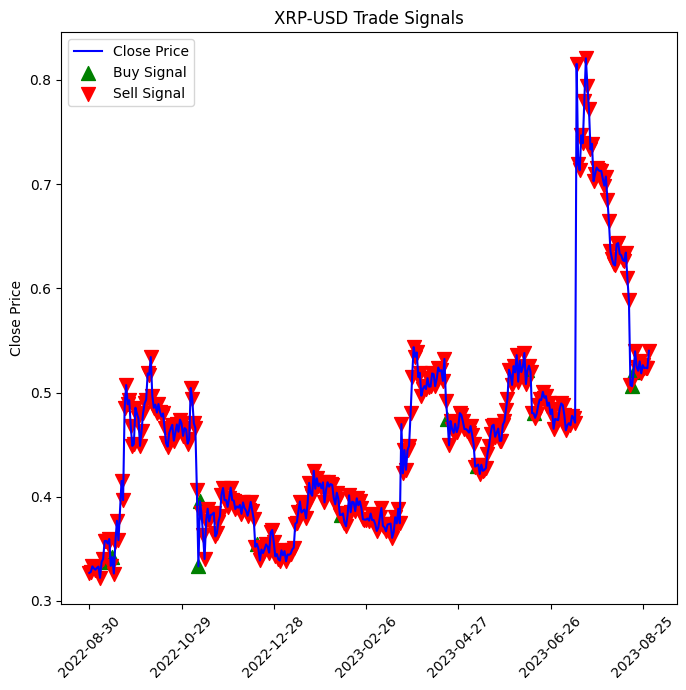

In [60]:
import matplotlib.pyplot as plt
import pandas as pd



# Create a DataFrame from the data
df = pd.DataFrame({'Date': dates, 'Close': CLOSES_1, 'Actions':ACTIONS})


# Create buy and sell signals based on Actions column
buy_indices = [i for i, val in enumerate(df['Actions']) if val == 2]
sell_indices = [i for i, val in enumerate(df['Actions']) if val == 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the Close price
ax.plot(df['Date'], df['Close'], label='Close Price', color='b')

# Plot buy signals (green)
ax.scatter(df['Date'][buy_indices], df['Close'][buy_indices], marker='^', color='g', label='Buy Signal', s=100)

# Plot sell signals (red)
ax.scatter(df['Date'][sell_indices], df['Close'][sell_indices], marker='v', color='r', label='Sell Signal', s=100)

# Set x-axis labels to be every two months
plt.xticks(df['Date'][::60], rotation=45)

# Set y-axis label
ax.set_ylabel('Close Price')

# Add a legend
ax.legend()

# Set the title
plt.title('XRP-USD Trade Signals')

# Show the plot
plt.tight_layout()
plt.show()

In [61]:
dates = test_env.asset_data.frame.index
print(CAPITAL)
print(len(dates))

100000
365


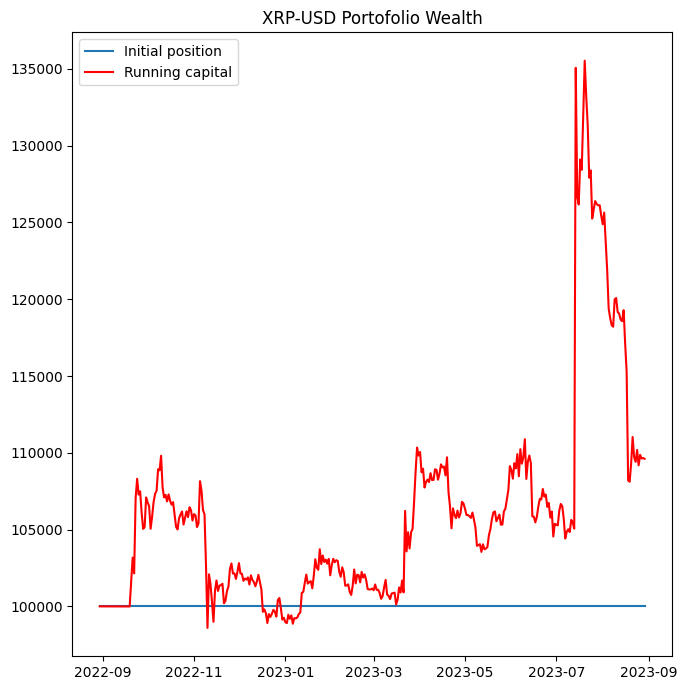

In [62]:
fig, ax = plt.subplots(figsize=(7, 7))


CAPITALS1=[CAPITAL]+CAPITALS[0]
ax.plot(dates,np.ones(len(dates))*CAPITAL, label='Initial position')
ax.plot(dates,CAPITALS1, label = 'Running capital', color='r')

# Add a legend
ax.legend()

# Show the plot
plt.title('XRP-USD Portofolio Wealth')
plt.tight_layout()
plt.show()


#plt.plot(dates,CAPITALS_1)